# Logistic regression using from scratch python implementation

In this notebook we will use the logistic regression model to classify the wine dataset from the UCI repository. You can find the implementation in `data/model.py`.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

from src.model import LogisticRegression 

Load data and rename columns.

Target is defined as:
- target=1 if quality >= 6.5
- target=0 if quality < 6.5

In [2]:
data = pd.read_csv("data/winequality-red.csv")
data["target"] = data["quality"] >= 6.5
data["target"] = data["target"].astype(int)
data.drop("quality", axis=1, inplace=True)
cols_pred = data.columns[:-1].tolist()

create_naming = (
    lambda x: x.replace(" ", "_")
    .replace("(", "")
    .replace(")", "")
    .replace("/", "_")
    .replace("-", "_")
    .lower()
)
data.columns = [create_naming(col) for col in data.columns]
cols_pred = data.columns[:-1].tolist()

Use standard scaler to scale the data.

Next we will oversample the data with SMOTE.

Split the data into train and test sets (80/20).

In [3]:
# Scale data
scaler = StandardScaler()
data[cols_pred] = scaler.fit_transform(data[cols_pred])
print(scaler.mean_)
print(scaler.scale_)

# Oversampling with SMOTE
print(data["target"].value_counts())
print(data.shape)
oversample = RandomOverSampler(sampling_strategy="minority")
X = data[cols_pred].values
y = data["target"].values
X_samp, y_samp = oversample.fit_resample(X, y)
data = pd.DataFrame(
    np.concatenate((X_samp, y_samp.reshape(-1, 1)), axis=1),
    columns=cols_pred + ["target"],
)
print(data["target"].value_counts())
print(data.shape)

# Split data
train = data.sample(frac=0.8, random_state=42)
test = data.drop(train.index)

[ 8.31963727  0.52782051  0.27097561  2.5388055   0.08746654 15.87492183
 46.46779237  0.99674668  3.3111132   0.65814884 10.42298311]
[1.74055180e+00 1.79003704e-01 1.94740214e-01 1.40948711e+00
 4.70505826e-02 1.04568856e+01 3.28850367e+01 1.88674370e-03
 1.54338181e-01 1.69453967e-01 1.06533430e+00]
target
0    1382
1     217
Name: count, dtype: int64
(1599, 12)
target
0.0    1382
1.0    1382
Name: count, dtype: int64
(2764, 12)


In [4]:
model = LogisticRegression(g_lambda=0.001, tol=1e-4, max_iter=1000)
model.fit(train[cols_pred], train["target"])

weights = {}
for c, w in zip(cols_pred, model.weights):
    weights[c] = w
weights["bias"] = model.bias
weights

{'fixed_acidity': 0.36695081773625804,
 'volatile_acidity': -0.25161280530391084,
 'citric_acid': -0.3600975531114141,
 'residual_sugar': 0.13383393530073348,
 'chlorides': -0.47961180164827233,
 'free_sulfur_dioxide': 0.04087980319774226,
 'total_sulfur_dioxide': -0.29869587818557347,
 'density': -0.6625940576926698,
 'ph': 0.3300429841333725,
 'sulphates': 0.5262087926124392,
 'alcohol': 1.1160097814376844,
 'bias': -0.10125658296349985}

## Evaluation

In [5]:
df = train[["target"]].copy()
df["score"] = model.predict_proba(train[cols_pred])[:, 1]
df["pred"] = df["score"] >= 0.5
df["pred"] = df["pred"].astype(int)
pd.crosstab(df["target"], df["pred"])

pred,0,1
target,,
0.0,714,387
1.0,154,956


In [6]:
df = test[["target"]].copy()
df["score"] = model.predict_proba(test[cols_pred])[:, 1]
df["pred"] = df["score"] >= 0.5
df["pred"] = df["pred"].astype(int)
pd.crosstab(df["target"], df["pred"])

pred,0,1
target,,
0.0,175,106
1.0,31,241


Train AUC: 0.818
Test gini: 0.662
Test AUC: 0.831
Test gini: 0.662


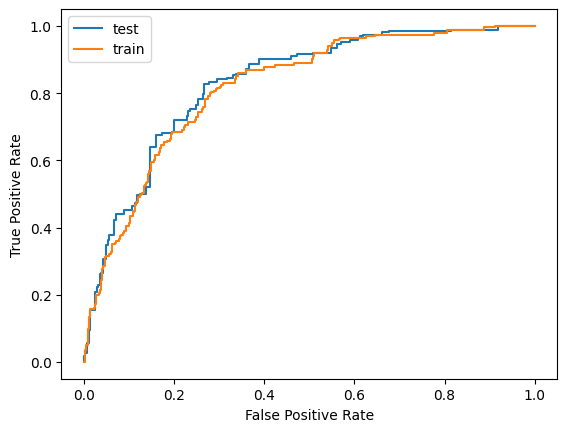

In [8]:
auc_train = roc_auc_score(train["target"], model.predict_proba(train[cols_pred])[:, 1])
auc_test = roc_auc_score(test["target"], model.predict_proba(test[cols_pred])[:, 1])
print(f"Train AUC: {auc_train:.3f}")
print(f"Test gini: {(auc_test - 0.5) * 2:.3f}")
print(f"Test AUC: {auc_test:.3f}")
print(f"Test gini: {(auc_test - 0.5) * 2:.3f}")

fpr, tpr, _ = roc_curve(test["target"], model.predict_proba(test[cols_pred])[:, 1])
plt.plot(fpr, tpr, label="test")
fpr, tpr, _ = roc_curve(train["target"], model.predict_proba(train[cols_pred])[:, 1])
plt.plot(fpr, tpr, label="train")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()